<a href="https://colab.research.google.com/github/AgniKoko/Image_Watermark_with_DCT/blob/main/watermark_dct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.fft import dct, idct,dst, idst
import urllib.request
from google.colab.patches import cv2_imshow

In [11]:
# Function to compute the 2D DCT of an image
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

# Function to compute the 2D inverse DCT of an image
def idct2(image):
    return idct(idct(image.T, norm='ortho').T, norm='ortho')

# Εφαρμογη Watermark

In [18]:
# image = cv2.imread('school_of_athens.png')
# cv2_imshow(image)
image = cv2.imread('school_of_athens.png',cv2.IMREAD_GRAYSCALE)
# cv2_imshow(image)
h, w = image.shape
print(image.shape)

(1200, 1920)


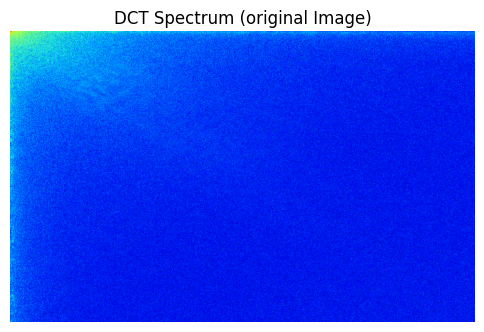

In [10]:
dct_image = dct2(image)

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(dct_image) + 1), cmap='jet')
plt.title('DCT Spectrum (original Image)')
plt.axis('off')
plt.show()

In [16]:
# watermark = cv2.imread('watermark.png')
# cv2_imshow(watermark)
watermark = cv2.imread('watermark.png',cv2.IMREAD_GRAYSCALE)
# cv2_imshow(watermark)
print(watermark.shape)

(1200, 1200)


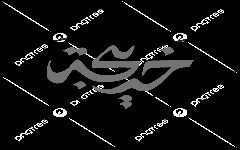

In [21]:
# Αλλαγή μεγέθους του watermark ώστε να ταιριάζει στον αριθμό των blocks (π.χ., 150 x 240)
# Αν τα blocks είναι 8x8:
blocks_h = h // 8  # 1200/8 = 150
blocks_w = w // 8  # 1920/8 = 240
watermark = cv2.resize(watermark, (blocks_w, blocks_h))  # (240, 150)
cv2_imshow(watermark)

In [58]:
# Μετατροπή σε δυαδική εικόνα (thresholding)
_, watermark_bin = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)

# Δημιουργία αντίγραφου της εικόνας για το watermarking
final_image = np.zeros_like(image, dtype=np.float32)
# Δημιουργία πίνακα για αποθήκευση των τιμών του επιλεγμένου συντελεστή (π.χ., [3,2])
watermark_map = np.zeros((blocks_h, blocks_w))

block_size = 8

In [59]:
# Παράγοντας κλιμάκωσης
alpha = 20

# Διαδικασία για κάθε μπλοκ
for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = image[i:i+block_size, j:j+block_size].astype(np.float32)
        dct_block = dct2(block)

        # Επιλογή του αντίστοιχου watermark bit για το block
        # Οι συντεταγμένες στο watermark αντίστοιχες με το block grid:
        wm_i = i // block_size
        wm_j = j // block_size
        bit = watermark_bin[wm_i, wm_j]
        # Ορισμός τιμής bit σε +1 ή -1
        b = 1 if bit == 1 else -1

        # Τροποποίηση του επιλεγμένου συντελεστή (π.χ. θέση [3,2])
        dct_block[3, 2] += alpha * b

        # Εφαρμογή της αντίστροφης DCT
        idct_block = idct2(dct_block)
        final_image[i:i+block_size, j:j+block_size] = idct_block

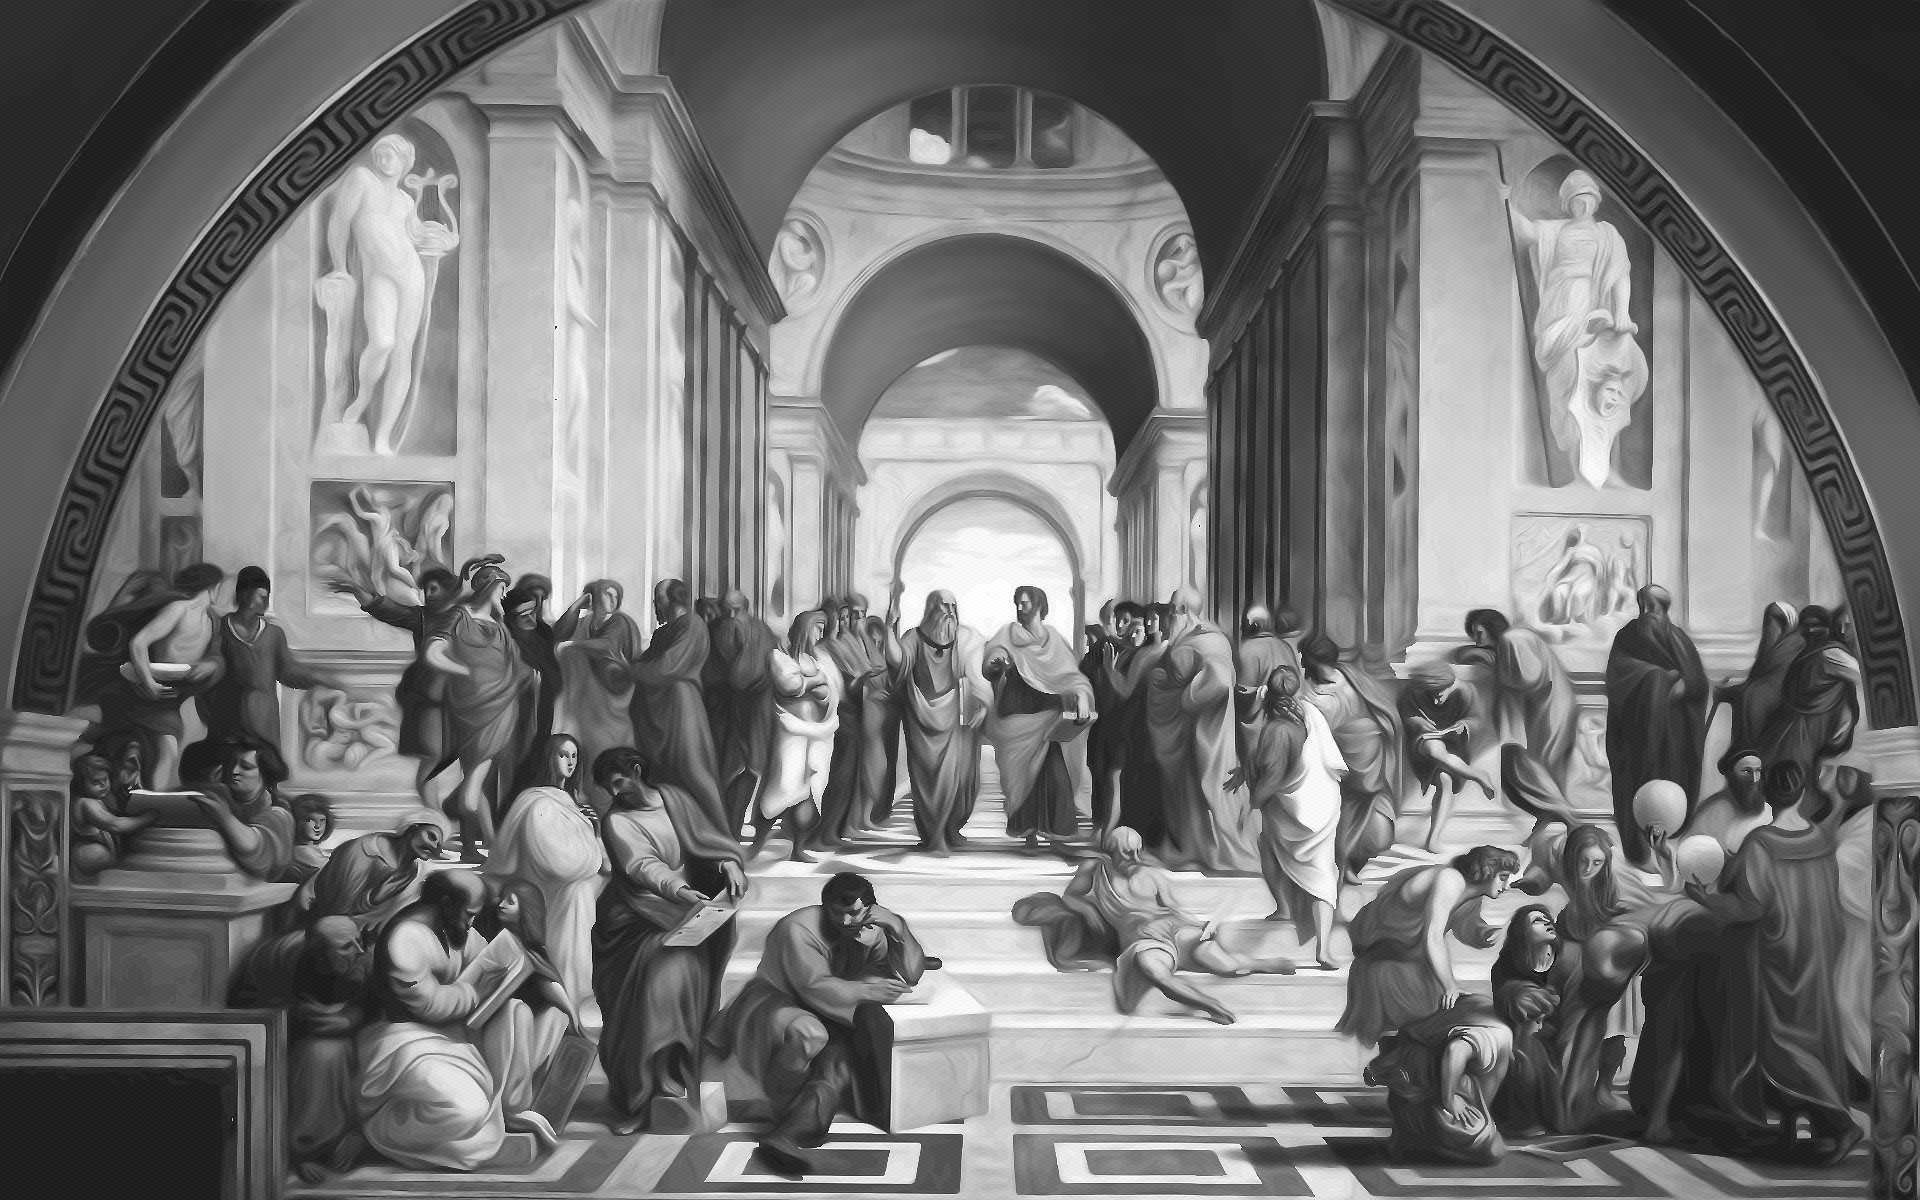

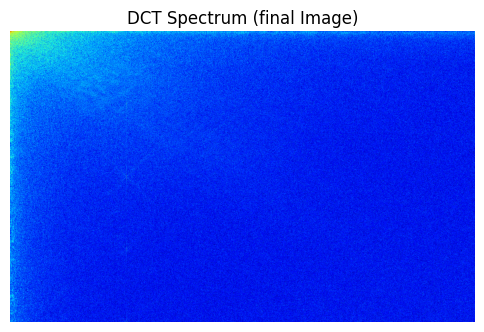

In [60]:
# Μετατροπή της τελικής εικόνας στο εύρος [0,255] και αποθήκευση
final_image = np.clip(final_image, 0, 255).astype(np.uint8)
cv2_imshow(final_image)

dct_image = dct2(final_image)

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(dct_image) + 1), cmap='jet')
plt.title('DCT Spectrum (final Image)')
plt.axis('off')
plt.show()

In [61]:
# Διέρμηση της εικόνας σε μπλοκ και εξαγωγή του συντελεστή από κάθε μπλοκ
for i in range(blocks_h):
    for j in range(blocks_w):
        # Απόκτηση του τρέχοντος μπλοκ
        block = final_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)

        # Εφαρμογή DCT στο μπλοκ
        dct_block = dct2(block)

        # Εξαγωγή του επιλεγμένου συντελεστή, π.χ. στη θέση [3,2]
        watermark_map[i, j] = dct_block[3, 2]

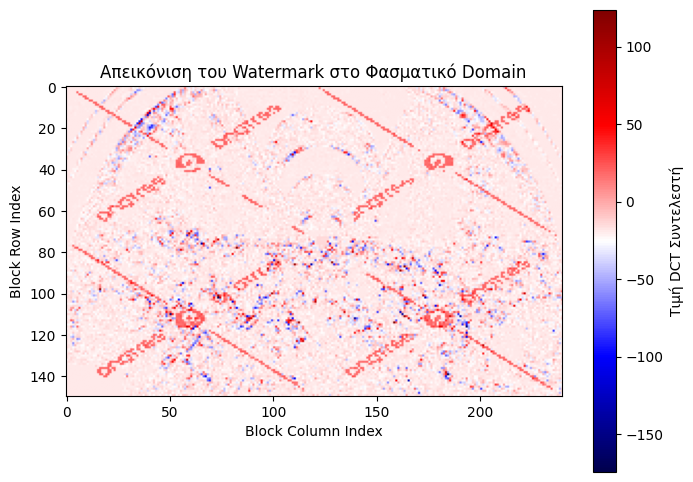

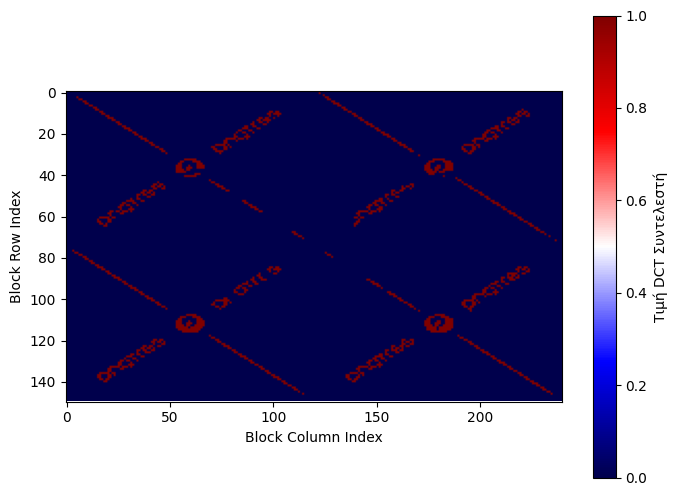

In [62]:
# Οπτικοποίηση του χάρτη των τιμών (το φασματικό αποτύπωμα του watermark)
plt.figure(figsize=(8, 6))
plt.imshow(watermark_map, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή')
plt.title('Απεικόνιση του Watermark στο Φασματικό Domain')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(watermark_bin, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή')
plt.title('')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')
plt.show()

# Ανακτηση Watermark

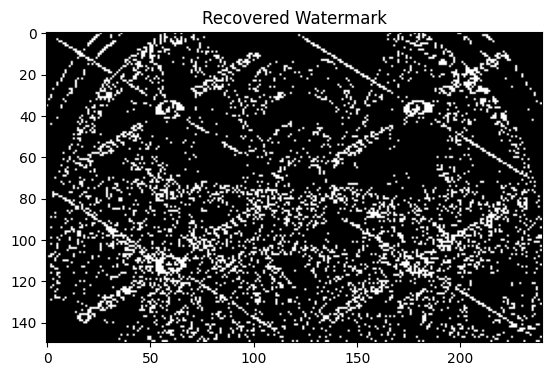

In [63]:
# Φόρτωση της τελικής watermarked εικόνας
watermarked_image = cv2.imread('final_image.png', cv2.IMREAD_GRAYSCALE)
h, w = watermarked_image.shape

block_size = 8
blocks_h = h // block_size
blocks_w = w // block_size

# Χάρτης για το ανακτημένο watermark
recovered_watermark = np.zeros((blocks_h, blocks_w))

# Κατώφλι για απόφαση (προσαρμόστε το ανάλογα με τις τιμές)
threshold = 0

for i in range(blocks_h):
    for j in range(blocks_w):
        block = watermarked_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
        dct_block = dct2(block)
        coeff_value = dct_block[3, 2]  # ο επιλεγμένος συντελεστής
        # Απόφαση: αν ο συντελεστής > threshold θεωρούμε bit 1, αλλιώς bit 0 (ή +1 και -1)
        recovered_watermark[i, j] = 1 if coeff_value > threshold else 0

# Οπτικοποίηση του ανακτημένου watermark
plt.imshow(recovered_watermark, cmap='gray')
plt.title("Recovered Watermark")
plt.show()
